In [1]:
import os
import math as m
from codes_gendrops_py.genSingleDrop import *
from codes_gendrops_py.fit_circle_through_3_points import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from cost_function import img2bw,ResizeImage
from PIL import Image
from remove_edge import *
import numpy as np

In [14]:
def cut_needle(img_ori,savepath='./'):
    path=savepath+"cut_needle.png" #%(sigma, volume0, rneedle)

    w_ori,h_ori=img_ori.size

    scaling_ori=300/w_ori # reshape the origin image to weight 100

    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))

    left_edge=np.zeros(w_ori2)
    right_edge=np.zeros(w_ori2)
    for i in range(h_ori2):
        for j in range(w_ori2):
            if A[i,j-1]>=125 and A[i,j]<125:
                #print('Left position',i,j)
                left_edge[i]=j
            if A[i,j-1]<=125 and A[i,j]>125:
                #print('Right position',i,j)
                right_edge[i]=j

    needle=np.abs(left_edge-right_edge)

    end=0
    #print(needle.shape[0])
    for j in range(needle.shape[0]-1):
        j=j+1
        #print((needle[j]-needle[0])/needle[0])
        if end == 0:
            if abs((needle[j]-needle[0])/needle[0])>0.05:
                stopline=j
                #print(j)
                end=end+1
    #print(stopline)

    img_WON=np.zeros((h_ori2-stopline,w_ori2))
    for i in range(h_ori2):
        if i>=stopline:
            img_WON[i-stopline,:]=A[i,:]
            
    img=Image.fromarray(np.uint8(img_WON))
    img.save(path)
    return path

In [18]:
def cost_new(img_ori,img_syn,x,width=100,K=1,output=0):
    print(img_ori.type,img_syn.type)
    w_ori,h_ori=img_ori.size
    w_syn,h_syn=img_syn.size
    

    scaling_ori=width/w_ori # reshape the origin image to width 100
    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)
    scaling_syn=K*scaling_ori
    w_syn2=int(scaling_syn*w_syn)
    h_syn2=int(scaling_syn*h_syn)
    x=int(x)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
    one=np.ones((w_ori2-h_ori2,w_ori2))*255
    A=np.row_stack((A,one))


    B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
    C=np.zeros((w_ori2,w_ori2))

    for i in range (w_ori2): # h
        for j in range(w_ori2): # w
            #print (h_ori2,w_ori2)
            #print(i,j)
            if j < x or j-x >= w_syn2 or i >= h_syn2 :
                 C[i,j]=A[i,j]
            else:
                if  A[i,j]==B[i,j-x]: # B[i-y,j-x]
                    C[i,j]=255
                else:
                    C[i,j]=0
    
    # pixel that same(T) different(F) and drop area
    t=0; f=0; 
    #drop_ori=0; drop_gen=0 
    for i in range (w_ori2):
        for j in range(h_ori2):
            if C[i,j]==0:
                f=f+1
            else:
                t=t+1
    lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
    accurancy=1-lost

    if output == 0:
        return lost
    elif output == 1:
        return C
    else:
        return C,lost

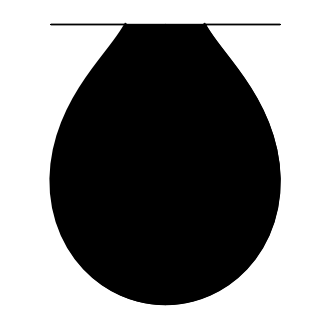

In [3]:
path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png')

svlrxyk=np.asarray((75,15,0.5,30,1))
sigma =svlrxyk[0]
v0    =svlrxyk[1]
rNe   =svlrxyk[2]
x     =svlrxyk[3]
k     =svlrxyk[4]



# open the origianl image and cut the needle
img_ori=Image.open(cut_needle(Image.open(path_ori)))

# generate the synthetic image
path=os.path.abspath('./images_gen')
path_syn=genSingleDrop(savepath=path,sigma=sigma,volume0=v0,rneedle=rNe,output=0)

im = io.imread(path_syn)
img_syn,path_syn = corp_margin(im)
img_syn=Image.open(path_syn)


In [4]:
width=100
K=k
w_syn,h_syn=img_syn.size
w_ori,h_ori=img_ori.size
### the image size can be changed here

scaling_ori=width/w_ori # reshape the origin image to width 100
w_ori2=int(scaling_ori*w_ori)
h_ori2=int(scaling_ori*h_ori)
scaling_syn=K*scaling_ori
w_syn2=int(scaling_syn*w_syn)
h_syn2=int(scaling_syn*h_syn)
x=int(x)

A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
one=np.ones((w_ori2-h_ori2,w_ori2))*255
A=np.row_stack((A,one))


B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
C=np.zeros((w_ori2,w_ori2))


for i in range (w_ori2): # h
    for j in range(w_ori2): # w
        #print (h_ori2,w_ori2)
        #print(i,j)
        if j < x or j-x >= w_syn2 or i >= h_syn2 :
             C[i,j]=A[i,j]
        else:
            if  A[i,j]==B[i,j-x]: # B[i-y,j-x]
                C[i,j]=255
            else:
                C[i,j]=0

In [5]:
# pixel that same(T) different(F) and drop area
t=0; f=0; 
#drop_ori=0; drop_gen=0 
for i in range (w_ori2):
    for j in range(h_ori2):
        if C[i,j]==0:
            f=f+1
        else:
            t=t+1
lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
accurancy=1-lost

In [50]:
print(C.shape)
print(w_ori2,w_ori2)
print(h_syn2,w_syn2)

(100, 100)
100 100
93 76


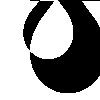

In [49]:
Image.fromarray(np.uint8(C))

(300, 223)


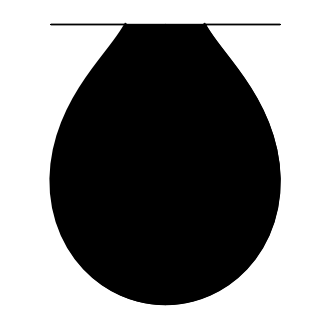

In [16]:
# input parameters
svrxk=np.asarray((75,15,0.5,30,1))
sigma = svrxk[0]
v0    = svrxk[1]
rNe   = svrxk[2]
x     = svrxk[3]
k     = svrxk[4]
output=0

# import img_ori
path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png')
img_ori=Image.open(cut_needle(Image.open(path_ori)))
print(img_ori.size)
# import img_syn
path_syn=genSingleDrop(savepath=os.path.abspath('./images_gen'),sigma=sigma,
                        volume0=v0,rneedle=rNe,output=0)
## Crop the edge of syn image
img_syn,path_syn = corp_margin(io.imread(path_syn))
img_syn=Image.open(path_syn)


In [20]:
lost=cost_new(x,img_syn,img_ori,k,output=output)

AttributeError: 'numpy.float64' object has no attribute 'type'

In [19]:
img_ori.size

(300, 223)